# Termowizja

## Prosta analiza obrazu termowizyjnego

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def I__median_and_morfology(I):
    I_median = cv2.medianBlur(I, 3)

    kernel = np.ones((3,3),np.uint8)
    I_result = cv2.erode(I_median,kernel)
    I_result = cv2.dilate(I_median,kernel)

    return I_result

In [3]:
def is_below(main_stat, sub_stat):
    return 0 < sub_stat[1] - main_stat[1] - main_stat[3] < 100

In [4]:
def is_between_edges(main_stat, sub_stat):
    return sub_stat[0] + sub_stat[2] > main_stat[0] and sub_stat[0] < main_stat[0] + main_stat[2]

In [5]:
def update_right_bottom(right_bottom, sub_stat):
    return ((sub_stat[0] + sub_stat[2]) if (right_bottom[0] < sub_stat[0] + sub_stat[2]) else right_bottom[0]), ((sub_stat[1] + sub_stat[3]) if (right_bottom[1] < sub_stat[1] + sub_stat[3]) else right_bottom[1])

def update_left_top(left_top, sub_stat):
    return sub_stat[0] if left_top[0] > sub_stat[0] else left_top[0], left_top[1]

def update_rectangle_tops(left_top, right_bottom, sub_stat):
    return update_left_top(left_top, sub_stat), update_right_bottom(right_bottom, sub_stat)


In [8]:
# patrzymy czy pod dołem wykrytego człowieka nie ma innego wykrytego obiektu
# jeśli jest to klasyfikujemy go jako część wykrytego człowieka i uktaulniamy współrzędne prostokąta

def I_indexation(I_input, I):
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(I)

    I_VIS = I_input # copy of the input image
    if (stats.shape[0] > 1): # are there any objects
        for (i, stat) in enumerate(stats):

            if i == 0 :
                continue
            if stat[3] / stat[2] > 2:
                left_top, right_bottom = (stat[0], stat[1]), (stat[0] + stat[2], stat[1] + stat[3])
                for (j, st) in enumerate(stats):
                    if (j == 0):
                        continue
                    if (is_below(stat, st) and is_between_edges(stat, st)):
                        left_top, right_bottom = update_rectangle_tops(left_top, right_bottom, st)
                cv2.rectangle(I_VIS,left_top, right_bottom,(255,0,0),2)
    return I_VIS, np.uint8(labels / retval * 255)

In [9]:

cap = cv2.VideoCapture('vid1_IR.avi')
while(cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
        break
    G = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    (T, I) = cv2.threshold(G, 35,255,cv2.THRESH_BINARY)
    I = I__median_and_morfology(I)
    I, tmp = I_indexation(I, I)
    cv2.imshow('IR',I)
    if cv2.waitKey(1) & 0xFF == ord('q'): # break the loop when the ’q32 Termowizja’ key is pressed
        break
cap.release()
cv2.destroyAllWindows()

# Zadanie dodatkowe - wzorzec probabilistyczny

### Zapisywanie sylwetek człowieka do pliku png

In [10]:
# patrzymy czy pod dołem wykrytego człowieka nie ma innego wykrytego obiektu
# jeśli jest to klasyfikujemy go jako część wykrytego człowieka i uktaulniamy współrzędne prostokąta

def I_indexation(I_input, I):
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(I)

    I_VIS = I_input # copy of the input image
    if (stats.shape[0] > 1): # are there any objects
        for (i, stat) in enumerate(stats):

            if i == 0 :
                continue
            if stat[3] / stat[2] > 2:
                left_top, right_bottom = (stat[0], stat[1]), (stat[0] + stat[2], stat[1] + stat[3])
                for (j, st) in enumerate(stats):
                    if (j == 0):
                        continue
                    if (is_below(stat, st) and is_between_edges(stat, st)):
                        left_top, right_bottom = update_rectangle_tops(left_top, right_bottom, st)
                return left_top, right_bottom
    return None, None

In [17]:
cap = cv2.VideoCapture('vid1_IR.avi')
iPedestrian = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
        break
    G = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    (T, I) = cv2.threshold(G, 35,255,cv2.THRESH_BINARY)
    I = I__median_and_morfology(I)
    left_top, right_top = I_indexation(I, I)
    if (left_top is not None):
        ROI = I[left_top[1]:right_top[1], left_top[0]:right_top[0]]
        cv2.imwrite('persons/sample_%06d.png' % iPedestrian,ROI)
        iPedestrian = iPedestrian + 1
    cv2.imshow('IR',I)
    if cv2.waitKey(1) & 0xFF == ord('q'): # break the loop when the ’q32 Termowizja’ key is pressed
        break
cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

### Tworzenie wzorca sylwetki

In [ ]:
img_indexes = [36, 37, 38, 210, 211, 212, 213, 214, 215, 382, 483, 484, 485, 510, 511, 512, 513, 514, 515, 631, 632, 633, 634, 711, 712, 713, 714, 905, 906, 907, 976, 977, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1115]


len(img_indexes)

40

In [11]:
import os

image_folder = "persons"

probabilistic_image = np.zeros((192,64))

for iPedestrian in img_indexes:
    filename = 'sample_%06d.png' % iPedestrian
    I = cv2.imread(os.path.join(image_folder, filename))
    I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
    I = cv2.resize(I, (64, 192))
    I = I / np.max(I)
    probabilistic_image += I
probabilistic_image = probabilistic_image / 40
plt.imshow(probabilistic_image, 'gray') 
cv2.imwrite('wzorzec.png', probabilistic_image * 255)

NameError: name 'img_indexes' is not defined

### Detekcja obiektów

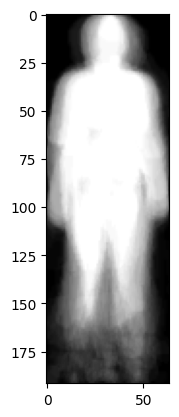

In [12]:
I = cv2.imread('wzorzec.png')
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
I = I.astype('uint8')
I = I / np.max(I)
plt.imshow(I, 'gray')

In [13]:
PDM1 = I
PDM0 = np.ones((192, 64)) - I

In [14]:
def IoU(rect1, rect2):
    x1, y1, w1, h1 = rect1[1], rect1[0], 64, 192
    x2, y2, w2, h2 = rect2[1], rect2[0], 64, 192
    left = max([x1, x2])
    right = min([x1+w1, x2+w2])
    top = max([y1, y2])
    bottom = min([y1+h1, y2+h2])
    area1 = max([(right - left), 0]) * max([(bottom - top), 0])
    area2 = (w1 * h1) + (w2 * h2) - area1
    IoU = area1/area2
    return IoU

NotFound before append: 0
NotFound after append: 1
before remove: 1
before remove: 1
before remove: 1
NotFound before append: 1
NotFound after append: 2
before remove: 2
before remove: 2
before remove: 2
before remove: 2
before remove: 2
before remove: 2
before remove: 2
before remove: 2
before remove: 2
before remove: 2
before remove: 2
before remove: 2
before remove: 2
before remove: 2
before remove: 2
before remove: 2
NotFound before append: 2
NotFound after append: 3
before remove: 3
before remove: 3
before remove: 3
before remove: 3
before remove: 3
before remove: 3
before remove: 3
before remove: 3
before remove: 3
before remove: 3
before remove: 3
before remove: 3
before remove: 3
before remove: 3
before remove: 3
before remove: 3
before remove: 3
before remove: 3
before remove: 3
before remove: 3
before remove: 3
before remove: 3
before remove: 3
before remove: 3
before remove: 3
before remove: 3
before remove: 3
before remove: 3
before remove: 3
before remove: 3
before remove:

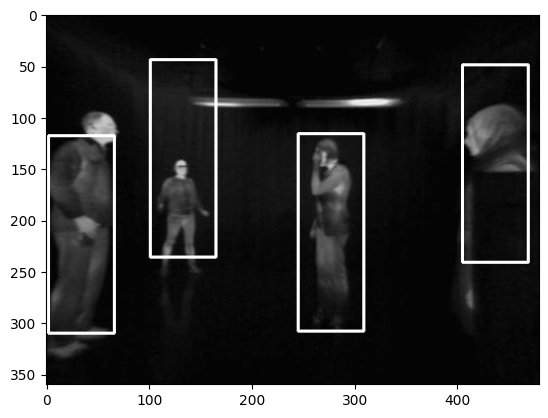

In [16]:
test_frame = cv2.imread('frames/frame_%06d.png' % 3090)
test_frame = cv2.cvtColor(test_frame, cv2.COLOR_BGR2GRAY)
(T, I) = cv2.threshold(test_frame, 35,255,cv2.THRESH_BINARY)
result = np.zeros((360,480), np.float32)
for i in range(192 // 2, test_frame.shape[0] - (192 // 2)):
    for j in range(64 // 2, test_frame.shape[1] - 64 // 2):
        prob = 0
        prob = np.sum(I[i - 192 // 2:i + 192 // 2, j - 64 // 2:j + 64 // 2] * PDM1) + np.sum((1 - I[i - 192 // 2:i + 192 // 2, j - 64 // 2:j + 64 // 2]) * PDM0)
        result[i, j] = prob
result = result / np.max(np.max(result))
result_uint8 = np.uint8(result*255)
counter = 1
Rect1 = []
for i in range(192 // 2, test_frame.shape[0] - (192 // 2)):
    for j in range(64 // 2, test_frame.shape[1] - 64 // 2):
        if result_uint8[i, j] > 100:
            notFound = True
            for rect_index in range(len(Rect1)):
                rect = Rect1[rect_index]
                if IoU(rect[1], (i-192//2, j-64//2, i+192//2, j+64//2)) > 0.0:
                    notFound = False
                    if (result_uint8[i, j] > result_uint8[rect[1][0] + 192//2, rect[1][1]+64//2]):
                        print('before remove:', len(Rect1))
                        Rect1[rect_index] = (result_uint8[i, j], (i-192//2, j-64//2, i+192//2, j+64//2))
                    break
            if notFound:
                print('NotFound before append:', len(Rect1))
                Rect1.append((result_uint8[i, j], (i-192//2, j-64//2, i+192//2, j+64//2)))
                print('NotFound after append:', len(Rect1))
        fr = test_frame.copy()

for rect in Rect1:
    cv2.rectangle(test_frame,(rect[1][1], rect[1][0]),(rect[1][3], rect[1][2]),(255,0,0),2)
plt.imshow(test_frame, 'gray')
cv2.destroyAllWindows()
